# Train the Networks (Siamese, Action Embeddings)

### Imports

In [1]:
import sys
from pathlib import Path

# Add the src folder to sys.path
sys.path.append(str(Path().resolve().parent / "src"))

In [2]:
import torch
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from torchvision.transforms import functional as F
from PIL import Image
from sas_dataset import SasDataset
from siamese import EncoderModel, InverseModel, cross_entropy_loss_function
from action_embeddings import (
    ForwardModel,
    EmbeddingModel,
    RMSE_loss_function,
    store_embeddings,
)
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import pickle
import seaborn as sns

### Display random Image

Here the random image path from the folder: ../data/states


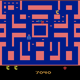

Displayed image: ../data/states/state_1735238143981_obs_tp1.png


In [3]:
# https://www.geeksforgeeks.org/show-random-picture-from-a-folder-in-python/
def get_random_image_path(folder_path):
    try:
        files = os.listdir(folder_path)
        
        images = [
            file
            for file in files
            if file.lower().endswith((".png", ".jpg", ".jpeg", ".gif"))
        ]

        if not images:
            print("No images found in the specified folder.")
            return None

        
        random_image = random.choice(images)
        random_image_path = os.path.join(folder_path, random_image)
        print(f"Here the random image path from the folder: {folder_path}")
        return random_image_path

    except Exception as e:
        print(f"An error occurred while selecting image randomly: {e}")
        return None


def display_image(image_path):
    try:
        if image_path and os.path.isfile(image_path):
            with Image.open(image_path) as img:
                img.show()
                print(f"Displayed image: {image_path}")
        else:
            print(f"Invalid image path: {image_path}")
    except Exception as e:
        print(f"An error occurred while displaying the image: {e}")
        
def show_random_image_from_folder(folder_path):
    random_image_path = get_random_image_path(folder_path)
    display_image(random_image_path)


folder_path = '../data/states'
if os.path.isdir(folder_path):
    show_random_image_from_folder(folder_path)
else:
    print(f" The specified folder does not exist: {folder_path}")

### Clean Dataset

In [3]:
# Load the dataset
csv_file = "../data/dataset.csv"
data = pd.read_csv(csv_file)

# Find rows where action is outside the valid range [0, 4]
invalid_actions = data[(data["action"] < 0) | (data["action"] > 4)]
len(invalid_actions)

print("Invalid actions:")
print(invalid_actions)

print("Number of invalid actions:", len(invalid_actions))


Invalid actions:
                                               state  action  \
271               ../data/states/state_271_obs_t.png       5   
1749             ../data/states/state_1749_obs_t.png       7   
3049             ../data/states/state_3049_obs_t.png       8   
3050             ../data/states/state_3050_obs_t.png       8   
3051             ../data/states/state_3051_obs_t.png       8   
...                                              ...     ...   
102619  ../data/states/state_1735246030587_obs_t.png       8   
102620  ../data/states/state_1735246030687_obs_t.png       8   
102621  ../data/states/state_1735246030786_obs_t.png       8   
103117  ../data/states/state_1735246080525_obs_t.png       8   
103118  ../data/states/state_1735246080626_obs_t.png       8   

                                            next_state   done  
271               ../data/states/state_271_obs_tp1.png  False  
1749             ../data/states/state_1749_obs_tp1.png  False  
3049             ../da

In [13]:
data = data[(data["action"] >= 0) & (data["action"] <= 4)]
data.to_csv("../data/dataset_cleaned.csv", index=False)

### Load Cleaned Dataset

In [3]:
def crop_bottom(img, crop_height):
    """
    Crop the bottom part of an image.

    Args:
        img (PIL.Image): Input image.
        crop_height (int): The height of the region to crop from the bottom.

    Returns:
        PIL.Image: Cropped image.
    """
    width, height = img.size  
    new_height = height - crop_height
    return F.crop(img, top=0, left=0, height=new_height, width=width)

In [4]:
csv_dataset = "../data/dataset_cleaned.csv"
transforms = transforms.Compose(
    [
        transforms.Lambda(lambda img: crop_bottom(img, crop_height=15)),
        #transforms.Resize((80, 80)),
        transforms.ToTensor(),  # Convert PIL Image to Tensor
        # transforms.Normalize( mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5] ),  # Normalize to [-1, 1] for RGB channels
        transforms.Normalize(mean=[0.5], std=[0.5]),  # Normalize to [-1, 1] for grayscale
    ]
)

dataset = SasDataset(csv_dataset, transforms, convert_to_grayscale=True, num_stacked_frames=4)

Check if actions are in the correct range (0-4):

In [6]:
print("Action min:", dataset.data["action"].min())
print("Action max:", dataset.data["action"].max())

Action min: 0
Action max: 4


Check if images got cropped correctly:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8509804].


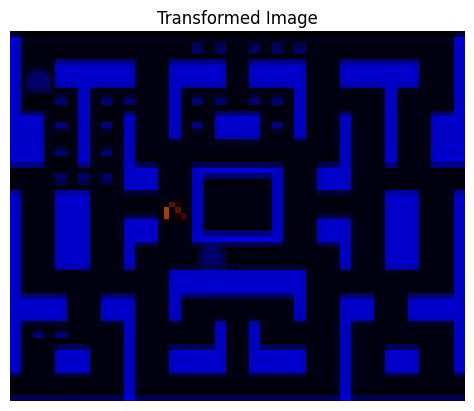

In [5]:
# Load an example image
img_path = "../data/states/state_1735213548910_obs_t.png"
img = Image.open(img_path).convert("RGB")

# Apply the transformation
transformed_img = transforms(img)

# Display the transformed image
plt.imshow(transformed_img.permute(1, 2, 0).numpy(), cmap="gray")
plt.title("Transformed Image")
plt.axis("off")
plt.show()


In [5]:
def split_dataset(dataset, TRAIN_RATIO=0.7, VAL_RATIO=0.2, TEST_RATIO=0.1):
    """
    Split PyTorch Dataset into training, validation, and test sets.
    Args:
        dataset: PyTorch Dataset
        TRAIN_RATIO: Float
        VAL_RATIO: Float
        TEST_RATIO: Float
    Returns:
        train_dataset: PyTorch Subset
        val_dataset: PyTorch Subset
        test_dataset: PyTorch Subset
    """
    assert (
        abs(TRAIN_RATIO + VAL_RATIO + TEST_RATIO - 1.0) < 1e-6
    ), "Ratios must sum to 1"

    # Calculate sizes for each split
    DATASET_SIZE = len(dataset)
    train_size = int(TRAIN_RATIO * DATASET_SIZE)
    val_size = int(VAL_RATIO * DATASET_SIZE)
    test_size = DATASET_SIZE - train_size - val_size  # Remaining samples for test set

    # Perform the split
    train_dataset, val_dataset, test_dataset = random_split(
        dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42),
    )

    return train_dataset, val_dataset, test_dataset


train_set, valid_set, test_set = split_dataset(dataset)

train_loader = DataLoader(train_set, batch_size=256, shuffle=True, num_workers=4)
val_loader = DataLoader(valid_set, batch_size=256, shuffle=False, num_workers=4)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False, num_workers=4)

In [6]:
for batch in train_loader:
    state, action, next_state, done = batch
    print("State shape:", state.shape)  
    print("Action shape:", action.shape)  
    print("Next State shape:", next_state.shape)  
    print("Done shape:", done.shape) 
    break

State shape: torch.Size([128, 4, 65, 80])
Action shape: torch.Size([128])
Next State shape: torch.Size([128, 4, 65, 80])
Done shape: torch.Size([128])


In [6]:
encoder = EncoderModel(in_channels=4, input_size=(65, 80)
) # 1x4x65x80 (4 stacked grayscale frames of 80x80)
inverse_model = InverseModel(encoder_dim=400, num_actions=5)
embedding_model = EmbeddingModel(action_size=5, embedding_size=50)
forward_model = ForwardModel(input_dim=450, output_dim=400)

optimizer = optim.Adam(
    list(encoder.parameters()) +
    list(embedding_model.parameters()) +
    list(forward_model.parameters()) +
    list(inverse_model.parameters()),
    lr=5e-4
)

In [ ]:
def train_combined_model(train_loader, val_loader, num_epochs=10, beta=0.5):
    """
    Train the combined model with forward and inverse losses, and validate on the validation set.

    Args:
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        num_epochs (int): Number of training epochs.
        beta (float): Weight for balancing the two losses.

    Returns:
        dict: History of training and validation losses and accuracy.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on device: {device}")
    encoder.to(device)
    embedding_model.to(device)
    forward_model.to(device)
    inverse_model.to(device)

    # Initialize history
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_accuracy": [],
        "val_accuracy": [],
    }
    best_val_loss = float("inf")
    patience_threshold = 5
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training phase
        encoder.train()
        embedding_model.train()
        forward_model.train()
        inverse_model.train()

        train_loss = 0.0
        total_correct = 0
        total_samples = 0

        for batch in train_loader:
            S_t, a_t, S_t_next, _ = batch
            S_t, a_t, S_t_next = (
                S_t.to(device),
                a_t.to(device),
                S_t_next.to(device),
            )

            # Encode states
            phi_S_t = encoder(S_t)
            phi_S_t_next = encoder(S_t_next)

            # Forward Model
            a_t_embedded = embedding_model(a_t)
            phi_hat_S_t_next = forward_model(phi_S_t, a_t_embedded)
            forward_loss = RMSE_loss_function(phi_hat_S_t_next, phi_S_t_next)

            # Inverse Model
            logits = inverse_model(torch.cat([phi_S_t, phi_S_t_next], dim=-1))
            inverse_loss = cross_entropy_loss_function(logits, a_t)

            # Total Loss
            total_loss = beta * forward_loss + (1 - beta) * inverse_loss
            train_loss += total_loss.item()

            # Compute accuracy
            _, predicted_action = torch.max(logits, dim=1)
            total_correct += (predicted_action == a_t).sum().item()
            total_samples += a_t.size(0)

            # Backward Pass and Optimization
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

        # Compute training accuracy
        train_accuracy = total_correct / total_samples

        # Validation phase
        encoder.eval()
        embedding_model.eval()
        forward_model.eval()
        inverse_model.eval()

        val_loss = 0.0
        total_correct = 0
        total_samples = 0

        with torch.no_grad():
            for batch in val_loader:
                S_t, a_t, S_t_next, _ = batch
                S_t, a_t, S_t_next = (
                    S_t.to(device),
                    a_t.to(device),
                    S_t_next.to(device),
                )

                # Encode states
                phi_S_t = encoder(S_t)
                phi_S_t_next = encoder(S_t_next)

                # Forward Model
                a_t_embedded = embedding_model(a_t)
                phi_hat_S_t_next = forward_model(phi_S_t, a_t_embedded)
                forward_loss = RMSE_loss_function(phi_hat_S_t_next, phi_S_t_next)

                # Inverse Model
                logits = inverse_model(torch.cat([phi_S_t, phi_S_t_next], dim=-1))
                inverse_loss = cross_entropy_loss_function(logits, a_t)

                # Total Loss
                total_loss = beta * forward_loss + (1 - beta) * inverse_loss
                val_loss += total_loss.item()

                # Compute accuracy
                _, predicted_action = torch.max(logits, dim=1)
                total_correct += (predicted_action == a_t).sum().item()
                total_samples += a_t.size(0)

        # Compute validation accuracy
        val_accuracy = total_correct / total_samples
        avg_val_loss = val_loss / len(val_loader)

        # Record metrics
        history["train_loss"].append(train_loss / len(train_loader))
        history["val_loss"].append(val_loss / len(val_loader))
        history["train_accuracy"].append(train_accuracy)
        history["val_accuracy"].append(val_accuracy)
        
        print(
            f"Epoch {epoch+1}/{num_epochs} | "
            f"Train Loss: {history['train_loss'][-1]:.4f} | "
            f"Val Loss: {history['val_loss'][-1]:.4f} | "
            f"Train Acc: {history['train_accuracy'][-1]:.2%} | "
            f"Val Acc: {history['val_accuracy'][-1]:.2%}"
        )

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0

            # Save best models
            torch.save(encoder.state_dict(), "../model-checkpoints/encoder.pth")
            torch.save(embedding_model.state_dict(), "../model-checkpoints/embedding_model.pth")
            torch.save(forward_model.state_dict(), "../model-checkpoints/forward_model.pth")
            torch.save(inverse_model.state_dict(), "../model-checkpoints/inverse_model.pth")
            print("Saved model checkpoints.")
        else:
            patience_counter += 1

        if patience_counter >= patience_threshold:
            print(
                f"Early stopping: Validation loss has not improved for {patience_threshold} epochs."
            )
            break
        
    store_embeddings(embedding_model, "../model-checkpoints/action_embeddings.pkl")
    print("Saved action embeddings.")

    return history


In [8]:
# add dropout layer to the encoder
history = train_combined_model(train_loader, val_loader, num_epochs=100, beta=0.3)

Training on device: cuda
Epoch 1/100 | Train Loss: 0.9911 | Val Loss: 0.9594 | Train Acc: 47.58% | Val Acc: 47.65%
Saved model checkpoints.
Epoch 2/100 | Train Loss: 0.9550 | Val Loss: 0.9458 | Train Acc: 47.58% | Val Acc: 47.65%
Saved model checkpoints.
Epoch 3/100 | Train Loss: 0.9464 | Val Loss: 0.9342 | Train Acc: 47.58% | Val Acc: 47.65%
Saved model checkpoints.
Epoch 4/100 | Train Loss: 0.9388 | Val Loss: 0.9268 | Train Acc: 47.58% | Val Acc: 47.65%
Saved model checkpoints.
Epoch 5/100 | Train Loss: 0.9308 | Val Loss: 0.9234 | Train Acc: 47.58% | Val Acc: 47.65%
Saved model checkpoints.
Epoch 6/100 | Train Loss: 0.9206 | Val Loss: 0.9038 | Train Acc: 47.73% | Val Acc: 48.59%
Saved model checkpoints.
Epoch 7/100 | Train Loss: 0.8844 | Val Loss: 0.8329 | Train Acc: 49.18% | Val Acc: 52.02%
Saved model checkpoints.
Epoch 8/100 | Train Loss: 0.8347 | Val Loss: 0.7795 | Train Acc: 51.79% | Val Acc: 55.08%
Saved model checkpoints.
Epoch 9/100 | Train Loss: 0.7906 | Val Loss: 0.7329 | T

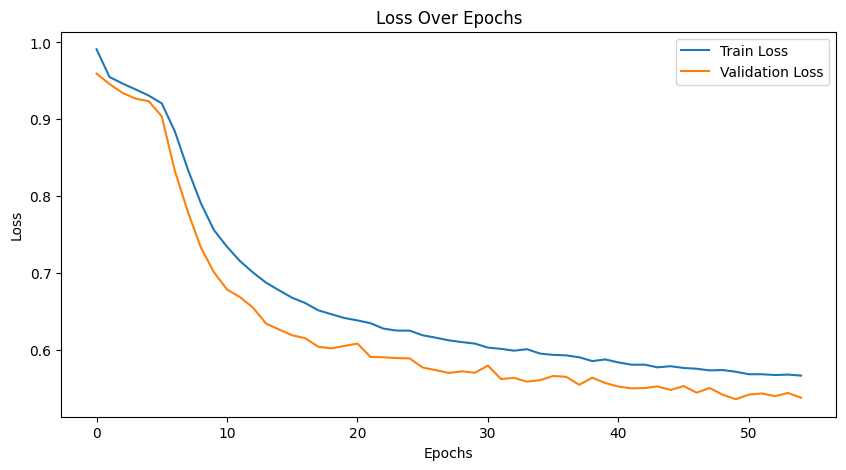

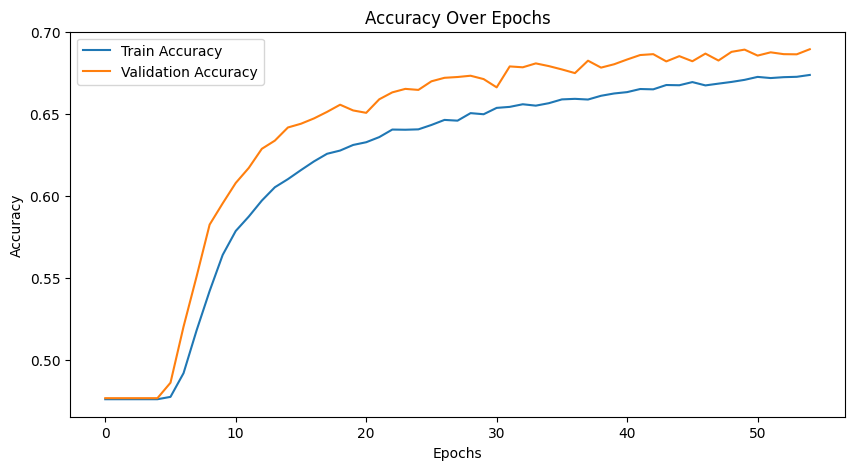

In [9]:
def plot_train_history(history):
    # Plot the losses
    plt.figure(figsize=(10, 5))
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()
    plt.show()

    # Plot the accuracies
    plt.figure(figsize=(10, 5))
    plt.plot(history["train_accuracy"], label="Train Accuracy")
    plt.plot(history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.legend()
    plt.show()

plot_train_history(history)

Embeddings Shape: (5, 50)


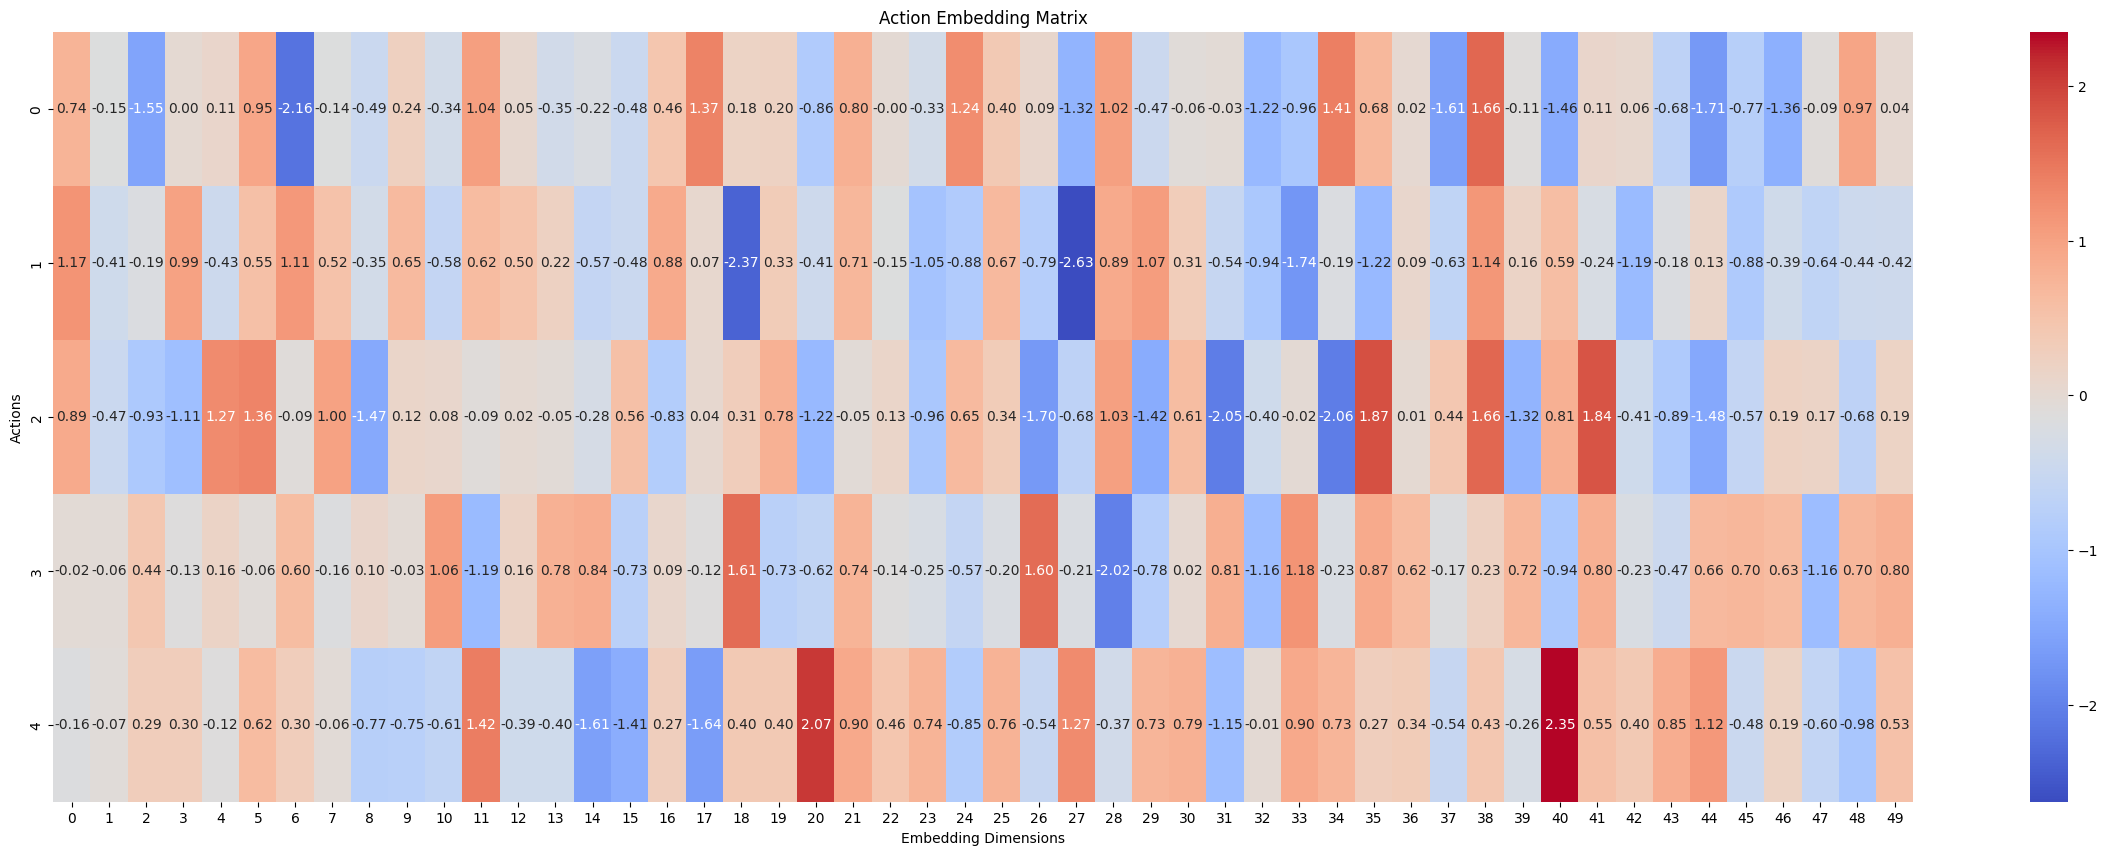

In [10]:
with open("../model-checkpoints/action_embeddings.pkl", "rb") as f:
    embeddings = pickle.load(f)

print("Embeddings Shape:", embeddings.shape)  # Should be (num_actions, embedding_size)

# Visualize embeddings using heatmap
plt.figure(figsize=(30, 10))
sns.heatmap(embeddings, annot=True, fmt=".2f", cmap="coolwarm")
plt.xlabel("Embedding Dimensions")
plt.ylabel("Actions")
plt.title("Action Embedding Matrix")
plt.show()


In [ ]:
def evaluate_model(encoder, forward_model, inverse_model, test_loader, beta=0.5):
    """
    Evaluate the model on the test dataset.

    Args:
        encoder (nn.Module): Encoder model.
        forward_model (nn.Module): Forward model.
        inverse_model (nn.Module): Inverse model.
        test_loader (DataLoader): DataLoader for the test dataset.
        beta (float): Weight for combining forward and inverse losses.

    Returns:
        dict: Evaluation metrics (average loss, forward loss, inverse loss, accuracy).
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Evaluating on device: {device}")
    
    # Set models to evaluation mode
    encoder.eval()
    forward_model.eval()
    inverse_model.eval()

    # Move models to the appropriate device
    encoder = encoder.to(device)
    forward_model = forward_model.to(device)
    inverse_model = inverse_model.to(device)

    total_loss = 0.0
    total_forward_loss = 0.0
    total_inverse_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation
        for batch in test_loader:
            state, action, next_state, _ = batch
            state, action, next_state = (
                state.to(device),
                action.to(device),
                next_state.to(device),
            )

            # Encode states
            phi_S_t = encoder(state)
            phi_S_t_next = encoder(next_state)

            # Forward Model: Predict next state embedding
            action_embedded = embedding_model(action)
            phi_hat_S_t_next = forward_model(phi_S_t, action_embedded)
            forward_loss = RMSE_loss_function(phi_hat_S_t_next, phi_S_t_next)

            # Inverse Model: Predict action
            logits = inverse_model(torch.cat([phi_S_t, phi_S_t_next], dim=-1))
            inverse_loss = cross_entropy_loss_function(logits, action)

            # Combined loss
            loss = beta * forward_loss + (1 - beta) * inverse_loss
            total_loss += loss.item()
            total_forward_loss += forward_loss.item()
            total_inverse_loss += inverse_loss.item()

            # Compute accuracy for inverse model
            _, predicted_action = torch.max(logits, dim=1)
            total_correct += (predicted_action == action).sum().item()
            total_samples += action.size(0)

    # Compute average losses and accuracy
    avg_loss = total_loss / len(test_loader)
    avg_forward_loss = total_forward_loss / len(test_loader)
    avg_inverse_loss = total_inverse_loss / len(test_loader)
    accuracy = total_correct / total_samples

    return {
        "average_loss": avg_loss,
        "forward_loss": avg_forward_loss,
        "inverse_loss": avg_inverse_loss,
        "accuracy": accuracy,
    }

In [ ]:
encoder = EncoderModel(in_channels=4, input_size=(65, 80))
forward_model = ForwardModel(input_dim=450, output_dim=400)
inverse_model = InverseModel(encoder_dim=400, num_actions=5)

encoder.load_state_dict(torch.load("../model-checkpoints/encoder.pth"))
forward_model.load_state_dict(
    torch.load("../model-checkpoints/forward_model.pth")
)
inverse_model.load_state_dict(
    torch.load("../model-checkpoints/inverse_model.pth")
)

/tmp/ipykernel_86023/1058108517.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load("../model-checkpoints/encoder.pth"))
/tmp/ipykernel_86

<All keys matched successfully>

In [13]:

metrics = evaluate_model(encoder, forward_model, inverse_model, test_loader, beta=0.3)
print(f"Test Loss: {metrics['average_loss']:.4f}")
print(f"Test Forward Loss: {metrics['forward_loss']:.4f}")
print(f"Test Inverse Loss: {metrics['inverse_loss']:.4f}")
print(f"Test Accuracy: {metrics['accuracy']:.2%}")

Evaluating on device: cuda
Test Loss: 0.5245
Test Forward Loss: 0.0117
Test Inverse Loss: 0.7442
Test Accuracy: 68.97%
